In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, signal
import cv2
import seaborn as sns
import pandas as pd
import pickle

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,load_model,model_from_yaml,model_from_json
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Activation
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
DATA_DIR='C:\g_images\downloads\originals'
CLASSES = ['cats','dogs','panda','bikes','horse']

In [ ]:
training_data=[] #list
training_label=[]

img_resize = 100

def self_generated_train_data():
    for c in CLASSES:
        path = os.path.join(DATA_DIR,c)
        class_no = CLASSES.index(c)
        for img in os.listdir(path):
            #print(os.path.join(path,img))
            img_array_bgr = cv2.imread(os.path.join(path,img))
            rgb_img = cv2.cvtColor(img_array_bgr, cv2.COLOR_BGR2RGB)
            rgb_image_resized = cv2.resize(rgb_img,(img_resize,img_resize))
            training_data.append(rgb_image_resized) #append array to a list
            training_label.append(class_no)
            
        print("Class %d loaded: %s "%(class_no,c))

In [ ]:
self_generated_train_data()

In [ ]:
# Convert into an array for model input
training_data = np.array(training_data)
training_label = np.array(training_label)

In [ ]:
print("Training data shape:",training_data.shape)
print("Training label shape:",training_label.shape)

In [ ]:
# save the resized data 

pickle_out=open("training_data_100px.pickle",'wb')
pickle.dump(training_data,pickle_out)
pickle_out.close()

pickle_out=open("training_label_100px.pickle",'wb')
pickle.dump(training_label,pickle_out)
pickle_out.close()

In [3]:
# to load the resized data
pickle_in = open("training_data_100px.pickle",'rb')
training_data = pickle.load(pickle_in)

pickle_in = open("training_label_100px.pickle",'rb')
training_label = pickle.load(pickle_in)

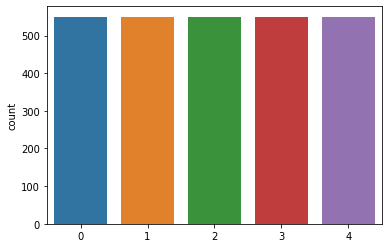

In [4]:
sns.countplot(training_label)

In [5]:
Class_label_counters = {label:list(training_label).count(label) for label in list(training_label)}
print('Class counts:',Class_label_counters)

Class counts: {0: 550, 1: 550, 2: 550, 3: 550, 4: 550}


In [6]:
total_classes = len(np.unique(training_label))
print('Total Number of classes:',total_classes)

Total Number of classes: 5


In [7]:
# one hot encoding
y_categorical = to_categorical(training_label,total_classes)

In [8]:
# Normalize the data 
training_data = training_data.astype('float32') / 255.

In [9]:
#shuffle the dataset
x_shuffle,y_shuffle = shuffle(training_data,y_categorical)

In [10]:
# test data split
X, X_test, Y, Y_test = train_test_split(x_shuffle,y_shuffle,test_size = 0.10)

In [11]:
# train and valid data split
X_train,X_valid,Y_train,Y_valid = train_test_split(X,Y,test_size = 0.20)

In [12]:
print("Test data shape after split:",X_test.shape)

Test data shape after split: (275, 100, 100, 3)


In [13]:
print("Training data shape after split:",X_train.shape)
print("Validation data shape after split:",X_valid.shape)

Training data shape after split: (1980, 100, 100, 3)
Validation data shape after split: (495, 100, 100, 3)


In [14]:
print("Training label shape after split:",Y_train.shape)
print("Validation label shape after split:",Y_valid.shape)

Training label shape after split: (1980, 5)
Validation label shape after split: (495, 5)


In [15]:
# Hyper-parameters settings
image_size = X_train.shape[1]
input_shape = (image_size, image_size, 3)
batch_size = 40
kernel_size = 3
pool_size = 2
dropout = 0.5

In [16]:
# model is a stack of CNN-ReLU-MaxPooling
model = Sequential(name='CNN_w/o Aug')

model.add(Conv2D(filters=16,kernel_size=kernel_size,activation='relu',input_shape=input_shape,))
model.add(MaxPooling2D(pool_size))

model.add(Conv2D(filters=16,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=16,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=32,kernel_size=kernel_size,activation='relu'))

model.add(Conv2D(filters=32,kernel_size=kernel_size,activation='relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(dropout))

model.add(Conv2D(filters=64,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=64,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=64,kernel_size=kernel_size,activation='relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(dropout))

model.add(Conv2D(filters=64,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=128,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=128,kernel_size=kernel_size,activation='relu'))

model.add(Flatten())
#model.add(Dropout(dropout))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(total_classes)) # output layer is 5-dim one-hot vector
model.add(Activation('softmax'))

W0909 18:26:15.967517 14440 deprecation.py:506] From C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


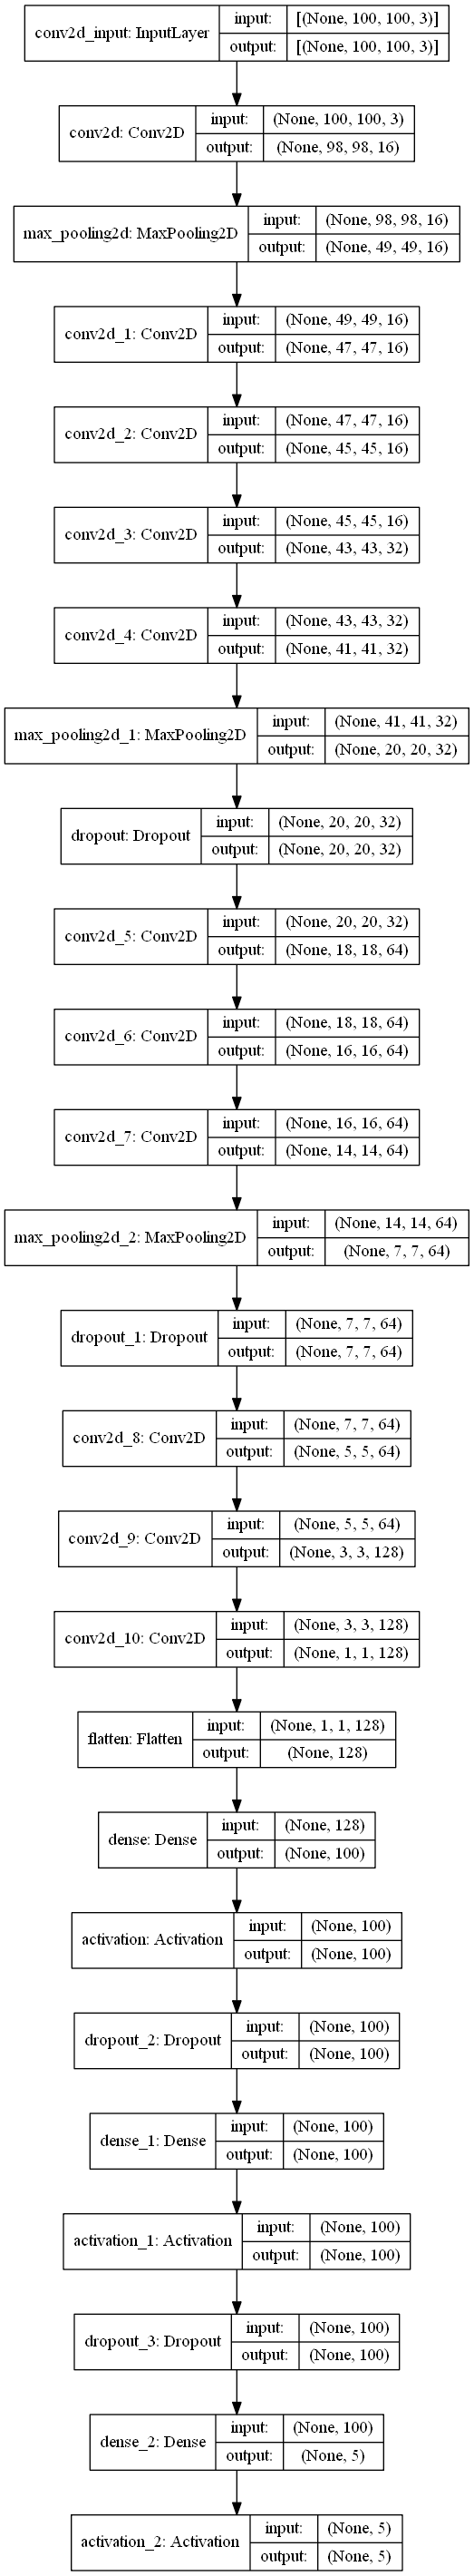

In [17]:
plot_model(model, to_file='cnn-woAG-self_dataset.png', show_shapes=True)

In [18]:
model.summary()

Model: "CNN_w/o Aug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 16)        2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        

In [19]:
# output shape of a layer
# for layer in model.layers:
#    print(layer.output_shape)

In [20]:
# loss function for one-hot vector encoding is categorical_crossentropy
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [21]:
early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0.001,
                                       patience=10,
                                       verbose=1, 
                                       mode='min',
                                       restore_best_weights=True)

In [22]:
model_checkpoint = ModelCheckpoint('CNN-woAG-Best.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [23]:
reduce_LR_OnPlateau = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.1,
                                        patience=5)

In [24]:
# train the network
history = model.fit(X_train, Y_train, 
                    epochs=50, 
                    batch_size=batch_size,
                    validation_data = (X_valid,Y_valid),
                    callbacks=[early_stopping,model_checkpoint,reduce_LR_OnPlateau])

Train on 1980 samples, validate on 495 samples
Epoch 1/50
1960/1980 [============================>.] - ETA: 0s - loss: 1.5359 - acc: 0.2735
Epoch 00001: val_acc improved from -inf to 0.30909, saving model to CNN-woAG-Best.h5
1980/1980 [==============================] - 9s 5ms/sample - loss: 1.5315 - acc: 0.2763 - val_loss: 1.4584 - val_acc: 0.3091
Epoch 2/50
1960/1980 [============================>.] - ETA: 0s - loss: 1.4047 - acc: 0.3500
Epoch 00002: val_acc improved from 0.30909 to 0.34545, saving model to CNN-woAG-Best.h5
1980/1980 [==============================] - 6s 3ms/sample - loss: 1.4044 - acc: 0.3495 - val_loss: 1.3327 - val_acc: 0.3455
Epoch 3/50
1960/1980 [============================>.] - ETA: 0s - loss: 1.2835 - acc: 0.3857
Epoch 00003: val_acc improved from 0.34545 to 0.36566, saving model to CNN-woAG-Best.h5
1980/1980 [==============================] - 6s 3ms/sample - loss: 1.2847 - acc: 0.3864 - val_loss: 1.2747 - val_acc: 0.3657
Epoch 4/50
1960/1980 [================

1960/1980 [============================>.] - ETA: 0s - loss: 0.5526 - acc: 0.7403
Epoch 00029: val_acc did not improve from 0.66263
1980/1980 [==============================] - 6s 3ms/sample - loss: 0.5529 - acc: 0.7394 - val_loss: 0.7968 - val_acc: 0.6606
Epoch 30/50
1960/1980 [============================>.] - ETA: 0s - loss: 0.5362 - acc: 0.7429
Epoch 00030: val_acc improved from 0.66263 to 0.66667, saving model to CNN-woAG-Best.h5
1980/1980 [==============================] - 6s 3ms/sample - loss: 0.5357 - acc: 0.7414 - val_loss: 0.8097 - val_acc: 0.6667
Epoch 31/50
1960/1980 [============================>.] - ETA: 0s - loss: 0.5459 - acc: 0.7316
Epoch 00031: val_acc did not improve from 0.66667
1980/1980 [==============================] - 6s 3ms/sample - loss: 0.5476 - acc: 0.7323 - val_loss: 0.7853 - val_acc: 0.6626
Epoch 32/50
1960/1980 [============================>.] - ETA: 0s - loss: 0.5354 - acc: 0.7362
Epoch 00032: val_acc did not improve from 0.66667
1980/1980 [============

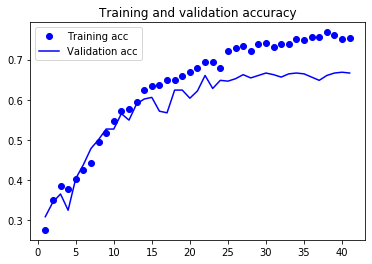

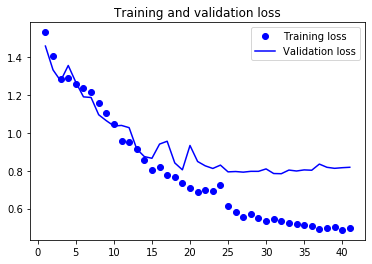

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [26]:
loss,acc = model.evaluate(X_test,Y_test)

275/275 [==============================] - 1s 2ms/sample - loss: 0.8593 - acc: 0.6582


In [27]:
def random_image_prediction(dataset=X_test):
    
    num_images = 10

    random_test_image_ind = np.random.randint(dataset.shape[0], size=num_images)

    plt.figure(figsize=(20, 6))

    for i,image_index in enumerate(random_test_image_ind):
        # display original
        ax = plt.subplot(1, num_images, i+1)
        plt.imshow(dataset[image_index])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        int_classID = model.predict_classes(np.expand_dims(dataset[image_index],axis=0))

        ax.set_title('Prediction:\n'+CLASSES[np.squeeze(int_classID)])


    plt.show()


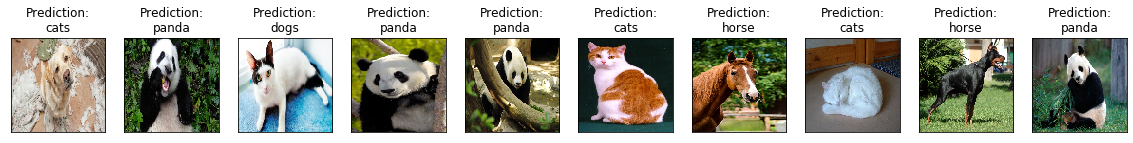

In [28]:
random_image_prediction()

### ========================================================================================= 

## 1) Filter's visualization

### A. Code 1

In [29]:
def filter_visualisation(model,layer,row_size,col_size):
    
    w,b = model.layers[layer].get_weights() #(filter_size,filter_size,rgb_depth/depth/channels,n_filters)
    
    w_filters = w.transpose(3,2,0,1) #(n_filters,rgb_depth/depth/channels,filter_size,filter_size)
    
    fig, ax = plt.subplots(row_size, col_size, figsize=(15,15))
    
    for filter_no in range(0,row_size):
        
        for channel in range(0,col_size):
            
            ax[filter_no][channel].imshow(w_filters[filter_no][channel], cmap='gray')
            

In [30]:
layer = 2
w,b = model.layers[layer].get_weights()
print('Number of filters:',w.shape[-1])
print('Depth per filters:',w.shape[-2])

Number of filters: 16
Depth per filters: 16


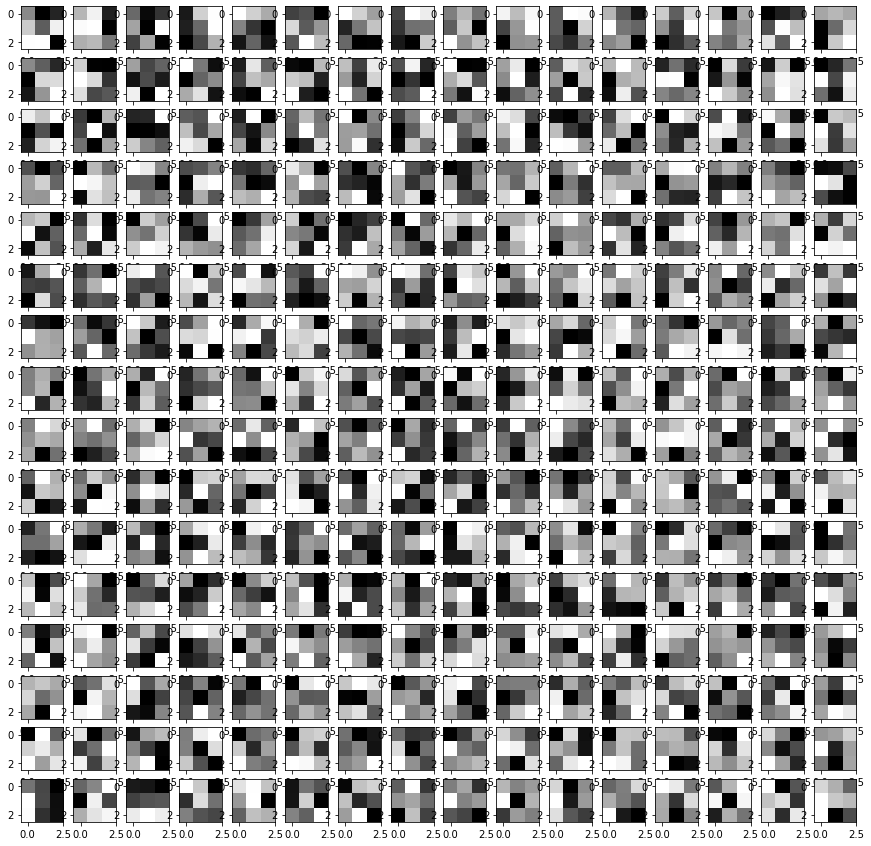

In [31]:
row_size = 16 #n_filters
col_size = 16  #depth per filters
filter_visualisation(model,layer,row_size,col_size)

### B. Code 2

In [32]:
def filter_visualisation(model,layer,row_size,col_size):
    
    fig, ax = plt.subplots(row_size, col_size, figsize=(15,15))
    
    for channel in range(0,col_size):
        
        w_filters = model.layers[layer].get_weights()[0][:,:,channel,:] #(filter_size,filter_size,n_filters)
        
        for filter_no in range(0,row_size):
                  
            ax[filter_no][channel].imshow(w_filters[:,:,filter_no], cmap='gray')
            

In [33]:
layer = 2
w,b = model.layers[layer].get_weights()
print('Number of filters:',w.shape[-1])
print('Depth per filters:',w.shape[-2])

Number of filters: 16
Depth per filters: 16


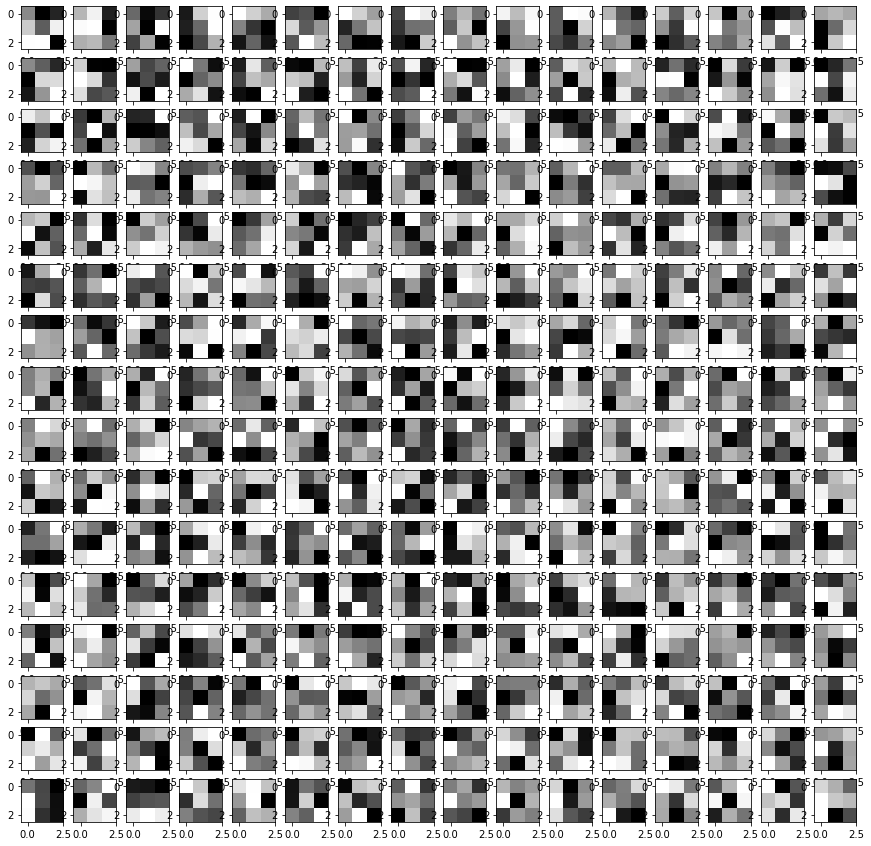

In [34]:
row_size = 16 #n_filters
col_size = 16  #depth/channels per filters
filter_visualisation(model,layer,row_size,col_size)

### ========================================================================================= 

## 2) Activation Map or Feature Map visualization

In [35]:
# list of layers
model.layers

In [36]:
# selecting only first 14 layers
layer_outputs = [layer.output for layer in model.layers[:14]]

In [37]:
layer_outputs

[<tf.Tensor 'conv2d/Relu:0' shape=(?, 98, 98, 16) dtype=float32>,
 <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 49, 49, 16) dtype=float32>,
 <tf.Tensor 'conv2d_1/Relu:0' shape=(?, 47, 47, 16) dtype=float32>,
 <tf.Tensor 'conv2d_2/Relu:0' shape=(?, 45, 45, 16) dtype=float32>,
 <tf.Tensor 'conv2d_3/Relu:0' shape=(?, 43, 43, 32) dtype=float32>,
 <tf.Tensor 'conv2d_4/Relu:0' shape=(?, 41, 41, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(?, 20, 20, 32) dtype=float32>,
 <tf.Tensor 'dropout/cond/Merge:0' shape=(?, 20, 20, 32) dtype=float32>,
 <tf.Tensor 'conv2d_5/Relu:0' shape=(?, 18, 18, 64) dtype=float32>,
 <tf.Tensor 'conv2d_6/Relu:0' shape=(?, 16, 16, 64) dtype=float32>,
 <tf.Tensor 'conv2d_7/Relu:0' shape=(?, 14, 14, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(?, 7, 7, 64) dtype=float32>,
 <tf.Tensor 'dropout_1/cond/Merge:0' shape=(?, 7, 7, 64) dtype=float32>,
 <tf.Tensor 'conv2d_8/Relu:0' shape=(?, 5, 5, 64) dtype=float32>]

In [38]:
# Creates a model that will return these layers outputs, given the model input
# When fed an image input, this model returns the values of the layer activations in the
# original model.
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

(100, 100, 3)
(1, 100, 100, 3)


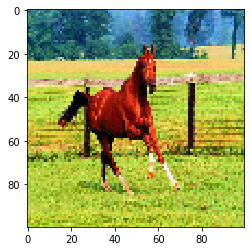

In [39]:
# load a normalized image to see the respective activation map

img = X_train[16]
print(img.shape)
img = np.expand_dims(img,axis=0)
print(img.shape) #image should be in the required shape
plt.imshow(img[0])
plt.show()


In [40]:
# Returns a list of Numpy arrays: one array per layer activation
activations = activation_model.predict(img)
# This will return a list of Numpy arrays 
# one array per layer activation  
type(activations) 

list

In [41]:
print("No. of layers selected:",len(activations))
print ("Size of output tensor of a particular layer:",activations[0].shape)

No. of layers selected: 14
Size of output tensor of a particular layer: (1, 98, 98, 16)


In [42]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 98, 98, 16)


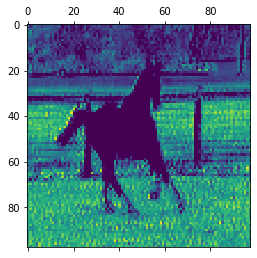

In [43]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

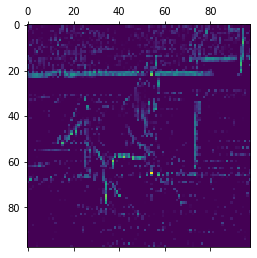

In [44]:
plt.matshow(first_layer_activation[0, :, :, 13], cmap='viridis')

### A. Code 1 (combining above steps)

In [45]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img)
 
def display_activation(activations, row_size, col_size, layer_number): 
    activation_maps = activations[layer_number]
    activation_maps_index = 0
    fig, ax = plt.subplots(row_size, col_size, figsize=(15,15))
    #plt.subplots_adjust(hspace=0)
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation_maps[0, :, :, activation_maps_index], cmap='viridis')
            activation_maps_index += 1

In [46]:
layer_number = 0 #change this layer number
n_filters = activations[layer_number].shape[-1]
Layer_name = model.layers[layer_number].name
print('Number of filters in '+Layer_name +' layer:',n_filters)

Number of filters in conv2d layer: 16


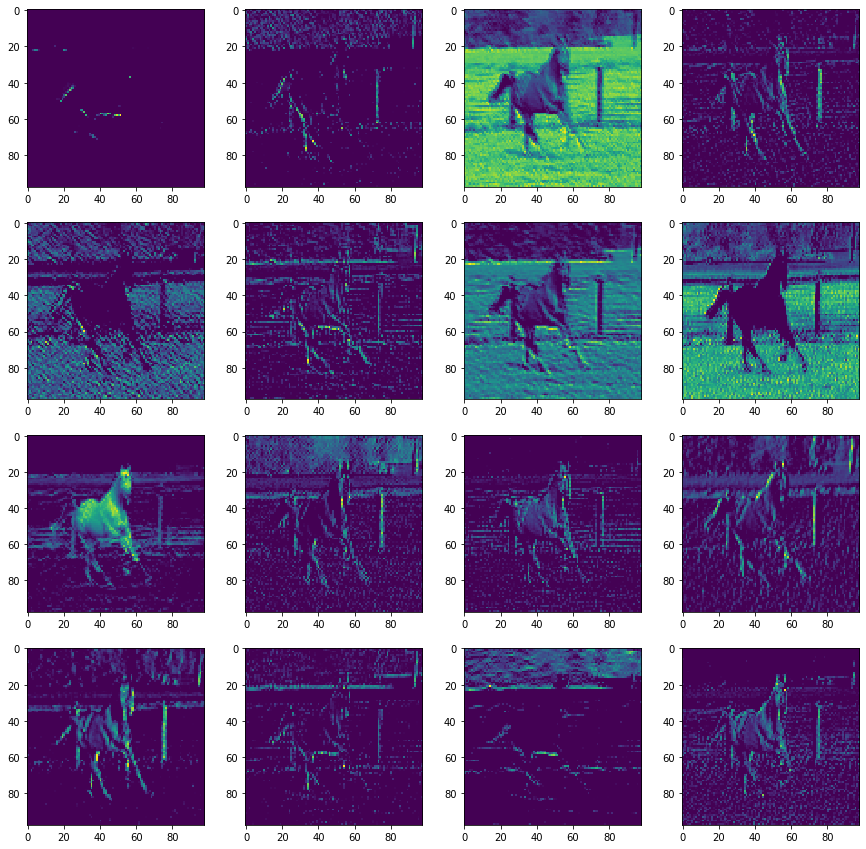

In [47]:
display_activation(activations, 4, 4, layer_number)

### B. Code 2 (taken from Deep learning with python by FRANÇOIS CHOLLET)

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


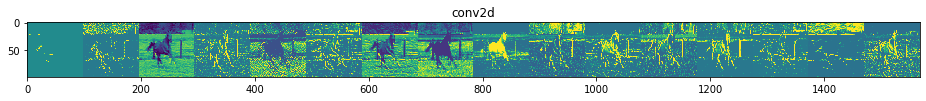

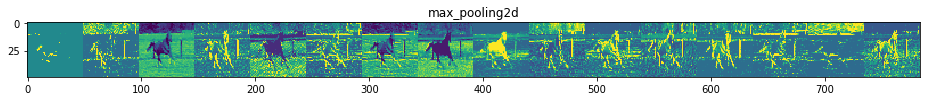

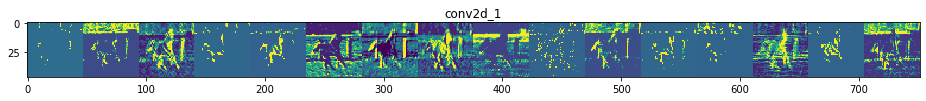

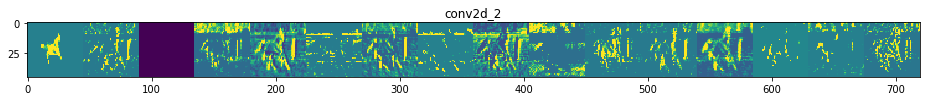

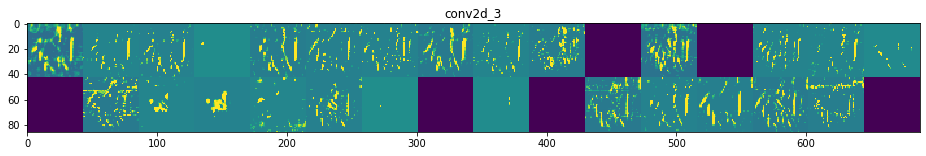

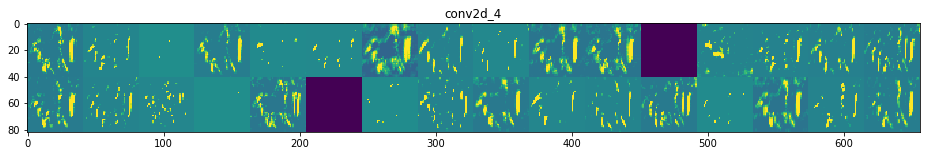

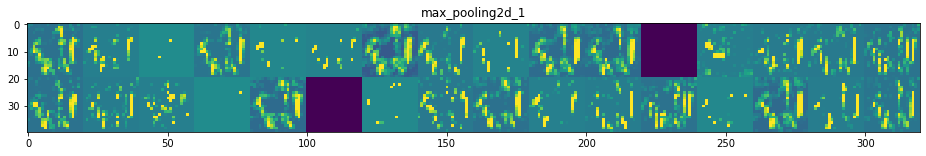

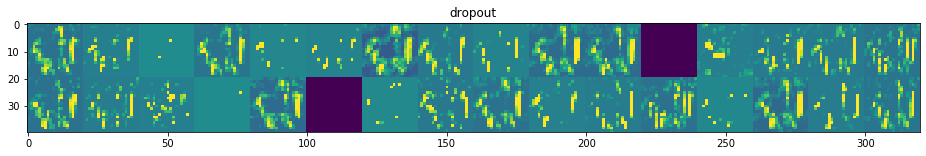

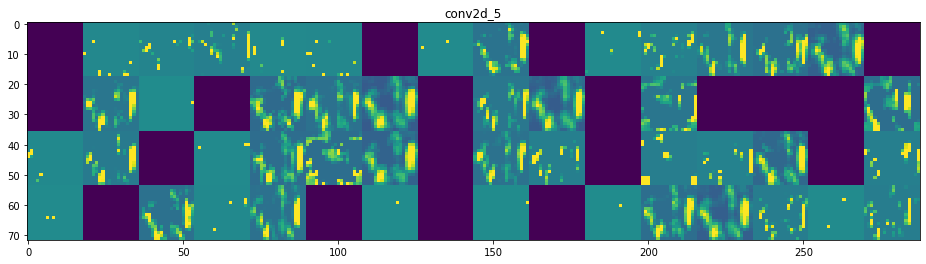

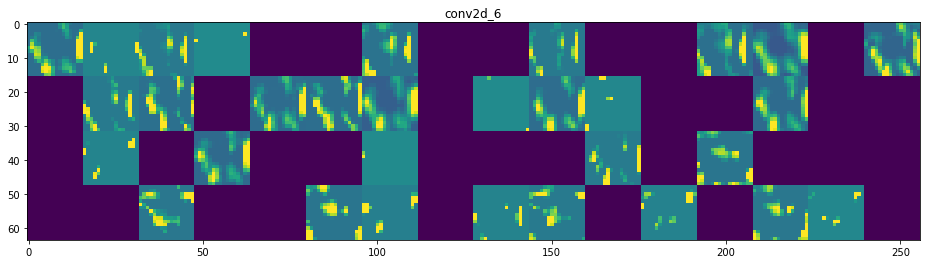

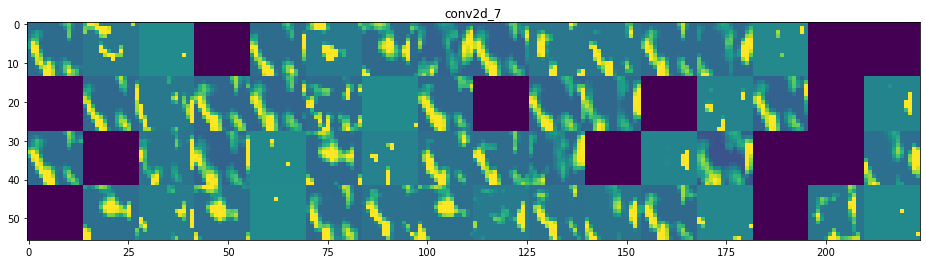

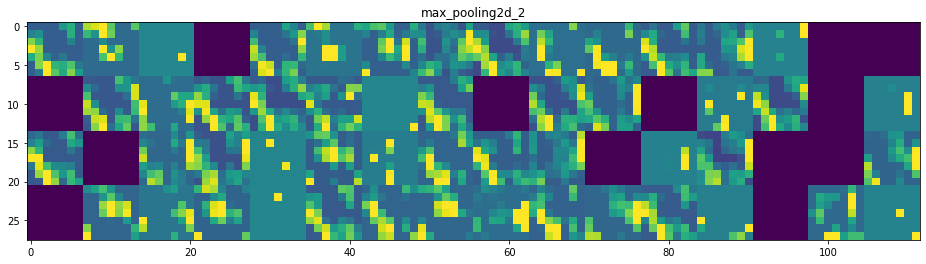

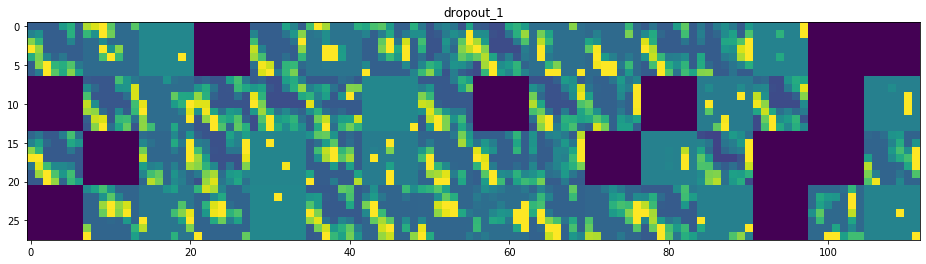

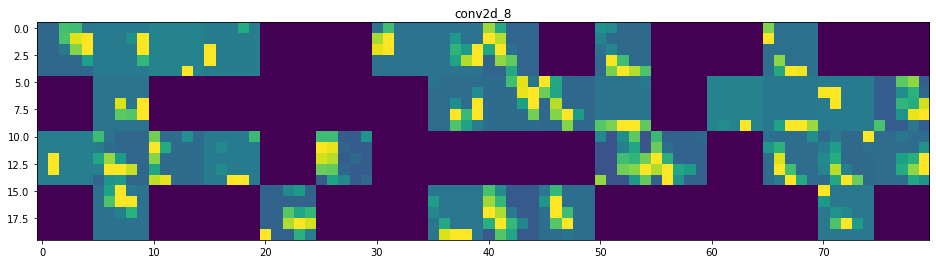

In [48]:
# Visualizing every channel in every intermediate activation

layer_names = []
for layer in model.layers[:14]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1] #total no. of feature maps
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### ========================================================================================= 

## 3) Saving and Loading the model

#### A. h5 format (easy to use)

In [49]:
# Saving and Loading Both Architecture and Weights in one File (h5 format)

# saving entire model
model.save('cnn_woAG_fullmodel.h5')


In [50]:
# loading whole model
model_h5 = load_model('cnn_woAG_fullmodel.h5')

# This will save the following four parameters in “cnn_woAG_fullmodel.h5” file:
# Model Architecture
# Model Weights
# training configuration (Loss and Optimizer,i.e., what you passed to compile)
# State of the optimizer allowing to resume training where you left.

W0909 18:37:03.773555 14440 deprecation.py:506] From C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0909 18:37:03.775554 14440 deprecation.py:506] From C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [51]:
prediction = model_h5.predict_classes(training_data)

In [52]:
# correct prediction
incorrects = np.nonzero(prediction!= training_label) # return the index of non zero entries
print((len(training_data)-len(incorrects[0]))/len(training_data)*100)

73.63636363636363


#### B. JSON format

In [53]:
# Saving/loading only a model's architecture to JSON format (it will not save the weights)
model_json = model.to_json()

# it will print the strutcure of model in human-readable format
# model_json

In [54]:
with open("model_cnnwoAG.json", "w") as json_file:
    json_file.write(model_json)

In [55]:
# load JSON 
json_file = open( 'model_cnnwoAG.json' , 'r' )
loaded_model_json = json_file.read()
json_file.close()

In [56]:
# create model from JSON
model_json_loaded = model_from_json(loaded_model_json)

In [57]:
# load the trained weights to the created model
model_json_loaded.load_weights('cnn_woAG_fullmodel.h5') 

In [58]:
model_json_loaded.summary()

Model: "CNN_w/o Aug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 16)        2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        

In [59]:
# As usual you can use the loaded model for prediction 
# However, unlike model.save(), this will not include the training config and the optimizer. 
# You need to call compile() again before using the model for training.

print('Predicted Prob:\n',model_json_loaded.predict(np.expand_dims(X_train[0],axis=0))) #for 1 image
# np.expand_dims was used to make input shape in acceptable format i.e. (1,H,W,nC)

print('\n')

print('Predicted Prob:\n',model_json_loaded.predict(X_train[0:5])) # for m images

print('\n')

random_image = np.random.randint(X_test.shape[0], size = 6) # 6 random images by index for testing

print('Predicted Class:',model_json_loaded.predict_classes(X_test[random_image]))

int_classID = model_json_loaded.predict_classes(X_test[random_image])

Predicted Prob:
 [[1.3797781e-04 1.6454147e-02 2.7011893e-07 1.3316663e-05 9.8339427e-01]]


Predicted Prob:
 [[1.3797768e-04 1.6454138e-02 2.7011791e-07 1.3316625e-05 9.8339427e-01]
 [5.9041552e-02 2.8917786e-01 2.6815070e-04 1.4522464e-03 6.5006018e-01]
 [2.9788118e-18 1.0937143e-17 8.6176777e-16 1.0000000e+00 8.3650036e-17]
 [4.0925018e-23 1.8872426e-22 4.1167464e-20 1.0000000e+00 1.7397379e-21]
 [1.1181342e-02 1.2548400e-01 3.2686006e-04 1.1894006e-03 8.6181843e-01]]


Predicted Class: [4 0 0 1 3 0]


In [60]:
def class_predicted(int_classID,image_No,Y_label):
    
    for i,j in zip(int_classID,image_No):
        
        print('Class Predicted:',CLASSES[i],', Actual Class:' ,CLASSES[np.argmax(Y_label[j])])
        

In [61]:
class_predicted(int_classID,random_image,Y_test)

Class Predicted: horse , Actual Class: dogs
Class Predicted: cats , Actual Class: cats
Class Predicted: cats , Actual Class: cats
Class Predicted: dogs , Actual Class: cats
Class Predicted: bikes , Actual Class: bikes
Class Predicted: cats , Actual Class: cats


#### C. YAML format

In [62]:
# Saving/loading only a model's architecture to YAML format (it will not save the weights)
model_yaml = model.to_yaml()

In [63]:
with open("model_cnnwoAG.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [64]:
# load YAML
yaml_file = open( 'model_cnnwoAG.yaml' , 'r' )
loaded_model_yaml = yaml_file.read()
yaml_file.close()

In [65]:
# create model from YAML
model_yaml_loaded = model_from_yaml(loaded_model_yaml)

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\saving\model_config.py:76: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(yaml_string)


In [66]:
# load the trained weights to the created model
model_yaml_loaded.load_weights('cnn_woAG_fullmodel.h5') 

In [67]:
# model_yaml_loaded.summary()

In [68]:
# As usual you can use the loaded model for prediction 
# However, unlike model.save(), this will not include the training config and the optimizer. 
# You need to call compile() again before using the model for training.

print('Predicted Prob:\n',model_yaml_loaded.predict(np.expand_dims(X_train[0],axis=0))) #for 1 image
# np.expand_dims was used to make input shape in acceptable format i.e. (1,H,W,nC)

print('\n')

print('Predicted Prob:\n',model_yaml_loaded.predict(X_train[0:5])) # for m images

Predicted Prob:
 [[1.3797781e-04 1.6454147e-02 2.7011893e-07 1.3316663e-05 9.8339427e-01]]


Predicted Prob:
 [[1.3797768e-04 1.6454138e-02 2.7011791e-07 1.3316625e-05 9.8339427e-01]
 [5.9041552e-02 2.8917786e-01 2.6815070e-04 1.4522464e-03 6.5006018e-01]
 [2.9788118e-18 1.0937143e-17 8.6176777e-16 1.0000000e+00 8.3650036e-17]
 [4.0925018e-23 1.8872426e-22 4.1167464e-20 1.0000000e+00 1.7397379e-21]
 [1.1181342e-02 1.2548400e-01 3.2686006e-04 1.1894006e-03 8.6181843e-01]]


In [69]:
prediction = model_yaml_loaded.predict_classes(training_data)

In [70]:
# correct prediction
incorrects = np.nonzero(prediction!= training_label)
print((len(training_data)-len(incorrects[0]))/len(training_data)*100)

73.63636363636363


In [ ]:
#  free memory resources, it will interrupt the kernel
# os.kill(os.getpid(), signal.SIGTERM)